In [142]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")

Seaborn version :  0.11.1


In [143]:
# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

In [144]:
for df in [train, test]:
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df.drop('FLAG_MOBIL', axis = 1, inplace = True)
    df['adj_DAYS_EMPLOYED_replace_0'] = -df.DAYS_EMPLOYED.replace({365243 : 0})
    df['DAYS_EMPLOYED_missing'] = (df.DAYS_EMPLOYED == 365243).astype('int')
    df['adj_begin_month'] = -df.begin_month
    df['adj_income_type'] = df.income_type
    df.loc[df.income_type == 'Student', 'adj_income_type'] = 'Working'
    df['adj_edu_type'] = df.edu_type 
    df.loc[df.edu_type == 'Academic degree', 'adj_edu_type'] = 'Higher education'
    df['adj_family_type'] = df['family_type']
    df['adj_family_type'].loc[(df.family_type == 'Single / not married')&(df.family_size - df.child_num == 2)] = 'Married'
    df['exp_num'] = 0
    df['exp_num'].loc[df.family_type == 'Married'] = 2
    df['exp_num'].loc[df.family_type == 'Civil marriage'] = 2
    df['exp_num'].loc[df.family_type == 'Separated'] = 1
    df['exp_num'].loc[df.family_type == 'Single / not married'] = 1
    df['exp_num'].loc[df.family_type == 'Widow'] = 1
    df['odd_family_size'] = 0
    df['odd_family_size'].loc[(df.family_size - df.child_num) != df.exp_num] = 1
    df['_single_parents'] = ((df.family_type == 'Single / not married')&(df.child_num != 0)).astype('int')
    df['_single_live'] = (df.family_size == 1).astype('int')
    df['adj_occyp_type'] = df.occyp_type.fillna('missing')
    df['_missing_occyp_type'] = df.occyp_type.isna().astype('int')
    df.loc[(df.DAYS_EMPLOYED == 365243)&(df.occyp_type.isna()), 'adj_occyp_type'] = 'inoccyp'
    df.loc[(df.DAYS_EMPLOYED != 365243)&(df.occyp_type.isna()), 'adj_occyp_type'] = 'non_enter'
    df['_age'] = -df.DAYS_BIRTH/365.25

    df['ID'] = \
    df['gender'].astype('str') + \
    df['car'].astype('str') + \
    df['reality'].astype('str') + '_' + \
    df['child_num'].astype('str') + '_' + \
    df['income_total'].astype('str') + '_' + \
    df['income_type'].astype('str') + '_' + \
    df['family_type'].astype('str') + '_' + \
    df['house_type'].astype('str') + '_' + \
    df['phone'].astype('str') + '_' + \
    df['email'].astype('str') + '_' + \
    df['family_size'].astype('str') + '_' + \
    df['DAYS_BIRTH'].astype('str') + '_' + \
    df['DAYS_EMPLOYED'].astype('str') + '_' + \
    df['occyp_type'].astype('str')     
    
    df['_card_num'] = df.groupby('ID').ID.transform(len)
    
    df['adj_begin_month'] = -df.begin_month
    df['_begin_month_max'] = df.groupby('ID').adj_begin_month.transform(max)
    df['_begin_month_mean'] = df.groupby('ID').adj_begin_month.transform(np.mean)
    df['_begin_month_min'] = df.groupby('ID').adj_begin_month.transform(min)

In [145]:
# 카드를 사용중인 사용자들을 완전히 구분하기 위해서는 다음과 같은 변수들이 필요하다
# ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'family_type', 'house_type', 'phone', 'email', 'family_size', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'occyp_type']
personal_info = train.drop(['credit', 'begin_month'], axis = 1).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
personal_info_test = pd.concat([train.drop(['credit'], axis = 1), test]).drop(['begin_month'], axis = 1).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)

In [146]:
personal_info = train.drop(['credit', 'begin_month'], axis = 1).drop_duplicates(subset="ID", keep='first', inplace=False, ignore_index=True)
personal_info_test = pd.concat([train.drop(['credit'], axis = 1), test]).drop(['begin_month'], axis = 1).drop_duplicates(subset="ID", keep='first', inplace=False, ignore_index=True)

for personal_df in [personal_info, personal_info_test]:
    ####### 양육비 변수 ######
    child_fee = (personal_df.income_total/personal_df.family_size)[(personal_df._age > 33) & (personal_df._age < 37) & (personal_df.child_num == 1)].mean()

    def child_fee_age_weights(x) : 
        from scipy.stats import norm
        sd = personal_df._age.std()
        return norm(35, scale = sd).pdf(x) / norm(35, scale = sd).pdf(35)
    personal_df['child_fees'] = (np.log(personal_df.child_num + 1)/np.log(2)) * (child_fee) * personal_df._age.apply(child_fee_age_weights)

    ####### 차유지비 변수 ######
    personal_df.income_total.median()*0.1
    def car_weight(x):
        _med = personal_df.income_total.median()
        _max = personal_df.income_total.max()
        if x < _med : 
            return 1
        else:
            return 1+(x-_med)/(_max-_med)*5
    personal_df['car_fees'] = personal_df.income_total.median()*0.1*personal_df.car*personal_df.income_total.apply(car_weight)

    ####### 여유금 변수 ######
    personal_df['_save_income'] = personal_df.income_total - personal_df.child_fees - personal_df.car_fees

    ####### 능력 변수 ######
    personal_df['_ability_income_per_age'] = 0
    personal_df['_ability_employ_per_age'] = 0
    personal_df['_ability_income_per_emp'] = 0
    for i in range(len(personal_df)) : 
        L_age = personal_df._age[i] - 3
        R_age = personal_df._age[i] + 3
        _gen = personal_df.gender[i]
        _ages_df = personal_df[['income_total', 'adj_DAYS_EMPLOYED_replace_0']][(personal_df._age > L_age) & (personal_df._age < R_age) & (personal_df.gender == _gen)]
        _med_income = _ages_df['income_total'].median()
        _std_income = _ages_df['income_total'].std()
        _med_employ = _ages_df['adj_DAYS_EMPLOYED_replace_0'].median()
        _std_employ = _ages_df['adj_DAYS_EMPLOYED_replace_0'].std()
        _n_df       = _ages_df.shape[0]
        personal_df.loc[i, '_ability_income_per_age'] = (personal_df.income_total.iloc[i] - _med_income) / (_std_income /np.sqrt(_n_df))
        personal_df.loc[i, '_ability_employ_per_age'] = (personal_df.adj_DAYS_EMPLOYED_replace_0.iloc[i] - _med_employ) / (_std_employ/np.sqrt(_n_df))

        if personal_df.adj_DAYS_EMPLOYED_replace_0.iloc[i] != 0:    
            L_emp = personal_df.adj_DAYS_EMPLOYED_replace_0 - 365
            R_emp = personal_df.adj_DAYS_EMPLOYED_replace_0 + 365
            _emps_df = personal_df.income_total[(personal_df.adj_DAYS_EMPLOYED_replace_0 > L_emp)&(personal_df.adj_DAYS_EMPLOYED_replace_0 < R_emp)]
            _med = _emps_df.median()
            _std = _emps_df.std()
            personal_df.loc[i, '_ability_income_per_emp'] = (personal_df.income_total.iloc[i] - _med)/(_std/np.sqrt(_n_df))

In [147]:
train  = pd.merge(train, personal_info[['ID', '_save_income', 'child_fees', 'car_fees', '_ability_income_per_age', '_ability_employ_per_age', '_ability_income_per_emp']], on = 'ID', how = 'left')
test = pd.merge(test, personal_info_test[['ID', '_save_income', 'child_fees', 'car_fees', '_ability_income_per_age', '_ability_employ_per_age', '_ability_income_per_emp']], on = 'ID', how = 'left')

In [148]:
for df in [train, test]:
    #카드 소유자가 가진 카드들에 할당할 수 있는 금액을 고려
    df['_income_per_cards']  = df.income_total / np.log(1+df._card_num)
    df['_save_per_cards']    = df._save_income / np.log(1+df._card_num)

    # 가족들에게 할당 될 수 있는 소득 그리고 여유자금을 고려
    df['_income_per_family'] = df.income_total / df.family_size
    df['_save_per_family']   = df._save_income / df.family_size
    
    df['ID'] = \
    df['gender'].astype('str') + \
    df['child_num'].astype('str') + '_' + \
    df['income_total'].astype('str') + '_' + \
    df['income_type'].astype('str') + '_' + \
    df['house_type'].astype('str') + '_' + \
    df['family_size'].astype('str') + '_' + \
    df['DAYS_BIRTH'].astype('str') + '_' + \
    df['DAYS_EMPLOYED'].astype('str') + '_' + \
    df['occyp_type'].astype('str') 

In [149]:
# dont touch : original
features = ['gender', 'car', 'reality', 'child_num', 'income_total', 'adj_income_type', 'adj_edu_type', 
            'adj_family_type', 'house_type', '_age', 'adj_DAYS_EMPLOYED_replace_0', 'DAYS_EMPLOYED_missing',
            'adj_begin_month', 'work_phone', 'phone', 'email', 'adj_occyp_type', '_missing_occyp_type', 'odd_family_size', 
            '_single_parents', '_single_live', 'ID', '_card_num', '_begin_month_max', '_begin_month_mean', '_begin_month_min',
            '_income_per_cards', '_save_per_cards', '_income_per_family', '_save_per_family', '_save_income',
            '_ability_income_per_age', '_ability_employ_per_age', '_ability_income_per_emp']

In [150]:
features = ['gender', 'car', 'reality', 'child_num', 'adj_income_type', 'adj_edu_type', 
            'adj_family_type', 'house_type', '_age', 'adj_DAYS_EMPLOYED_replace_0',
            'adj_begin_month', 'work_phone', 'phone', 'email', 'adj_occyp_type', 
            'ID', '_begin_month_min',
            '_save_per_cards', '_save_per_family', '_save_income',
            '_ability_income_per_age']

In [103]:
features = ['gender', 'car', 'reality', 'child_num',
            'adj_income_type', 'adj_edu_type', 'adj_family_type', 'house_type', 'adj_occyp_type',
            'work_phone', 'phone', 'email',
            '_age',
            'adj_DAYS_EMPLOYED_replace_0', 'ID',
            '_income_per_family', '_save_income', 
            'adj_begin_month','_begin_month_min'            
           ]

In [172]:
features = ['gender', 
            'car', 
            'reality', 
            'child_num', 
            'income_total', 
            'adj_income_type', 
            'adj_edu_type', 
            'adj_family_type', 
            'house_type', 
            '_age', 
            'adj_DAYS_EMPLOYED_replace_0', 
            #'DAYS_EMPLOYED_missing',
            'adj_begin_month', '_begin_month_min', #'_begin_month_max', '_begin_month_mean', 
            'work_phone', 
            'phone', 
            'email', 
            'adj_occyp_type', 
            '_missing_occyp_type', 
            'odd_family_size', #'_single_parents', '_single_live', 
            'ID', 
            '_card_num', 
            '_income_per_family', #'_income_per_cards', 
            #'_save_income', '_save_per_cards', '_save_per_family', 
            #'_ability_income_per_age', '_ability_employ_per_age', '_ability_income_per_emp'
            ]

In [173]:
numerical_feats = train[features].dtypes[train[features].dtypes != "object"].index.tolist()
#numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train[features].dtypes[train[features].dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  16
Number of Categorical features:  6


In [174]:
train[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       26457 non-null  int64  
 1   car                          26457 non-null  int64  
 2   reality                      26457 non-null  int64  
 3   child_num                    26457 non-null  int64  
 4   income_total                 26457 non-null  float64
 5   adj_income_type              26457 non-null  object 
 6   adj_edu_type                 26457 non-null  object 
 7   adj_family_type              26457 non-null  object 
 8   house_type                   26457 non-null  object 
 9   _age                         26457 non-null  float64
 10  adj_DAYS_EMPLOYED_replace_0  26457 non-null  int64  
 11  adj_begin_month              26457 non-null  float64
 12  _begin_month_min             26457 non-null  float64
 13  work_phone      

In [175]:
target = 'credit'
X = train.drop(target, axis=1)[features]
y = train[target]
X_test = test[features]
cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']
print('category features : {}'.format(cat_cols))
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=None, train_size=0.2, random_state=42)

train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

model_cat = CatBoostClassifier()
model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, 
              early_stopping_rounds=100, verbose=50)

print(log_loss(y_valid, model_cat.predict_proba(X_valid)))

category features : ['adj_income_type', 'adj_edu_type', 'adj_family_type', 'house_type', 'adj_occyp_type', 'ID', 'gender', 'car', 'reality', 'phone', 'email', 'work_phone']
Learning rate set to 0.111635
0:	learn: 1.0334950	test: 1.0346033	best: 1.0346033 (0)	total: 20.1ms	remaining: 20s
50:	learn: 0.7525176	test: 0.7708038	best: 0.7708038 (50)	total: 689ms	remaining: 12.8s
100:	learn: 0.7216724	test: 0.7680199	best: 0.7679382 (98)	total: 1.47s	remaining: 13.1s
150:	learn: 0.6851342	test: 0.7677597	best: 0.7674492 (120)	total: 2.32s	remaining: 13s
200:	learn: 0.6562992	test: 0.7684131	best: 0.7674492 (120)	total: 3.15s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7674492162
bestIteration = 120

Shrink model to first 121 iterations.
0.7674492162100811


In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))
        
        

In [130]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

target = 'credit'
#X = train.drop(target, axis=1)[features]
#y = train[target]
#X_test = test[features]

In [87]:
X._age

0        38.053388
1        31.156742
2        52.257358
3        41.308693
4        41.169062
           ...    
26452    33.070500
26453    41.864476
26454    27.603012
26455    27.775496
26456    53.577002
Name: _age, Length: 26457, dtype: float64

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       26457 non-null  int64  
 1   car                          26457 non-null  int64  
 2   reality                      26457 non-null  int64  
 3   child_num                    26457 non-null  int64  
 4   adj_income_type              26457 non-null  object 
 5   adj_edu_type                 26457 non-null  object 
 6   adj_family_type              26457 non-null  object 
 7   house_type                   26457 non-null  object 
 8   adj_occyp_type               26457 non-null  object 
 9   work_phone                   26457 non-null  int64  
 10  phone                        26457 non-null  int64  
 11  email                        26457 non-null  int64  
 12  _age                         26457 non-null  float64
 13  adj_DAYS_EMPLOYE

In [53]:
categorical_feats + ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']

['adj_income_type',
 'adj_edu_type',
 'adj_family_type',
 'house_type',
 'adj_occyp_type',
 'ID',
 'gender',
 'car',
 'reality',
 'phone',
 'email',
 'work_phone']

In [182]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']
print('category features : {}'.format(cat_cols))

# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=1042, learning_rate=0.04, bootstrap_type ='Bernoulli')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['adj_income_type', 'adj_edu_type', 'adj_family_type', 'house_type', 'adj_occyp_type', 'ID', 'gender', 'car', 'reality', 'phone', 'email', 'work_phone']

----------------- Fold 0 -----------------

0:	learn: 1.0756098	test: 1.0760751	best: 1.0760751 (0)	total: 18.3ms	remaining: 54.8s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 0.7180489	test: 0.6926410	best: 0.6926410 (100)	total: 2.43s	remaining: 1m 9s
200:	learn: 0.7018289	test: 0.6844836	best: 0.6844836 (200)	total: 5.55s	remaining: 1m 17s
300:	learn: 0.6865242	test: 0.6817999	best: 0.6817999 (300)	total: 8.89s	remaining: 1m 19s
400:	learn: 0.6701846	test: 0.6806695	best: 0.6806242 (395)	total: 12.8s	remaining: 1m 23s
500:	learn: 0.6555075	test: 0.6799429	best: 0.6799395 (495)	total: 16.5s	remaining: 1m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6797508328
bestIteration = 539

Shrink model to first 540 iterations.
CV Log Loss Score: 0.679751

----------------- Fold 1 -----------------

0:	learn: 1.0753561	test: 1.0753218	best: 1.0753218 (0)	total: 19.3ms	remaining: 57.9s
100:	learn: 0.7173981	test: 0.6859178	best: 0.6859178 (100)	total: 2.38s	remaining: 1m 8s
200:	learn: 0.7009865	test: 0.6783389	best: 0.6783357 (198)	total: 5.46s	remaining: 1m 16s
300:	learn: 0.6873793	test: 0.6754243	best: 0.6754243 (300)	total: 

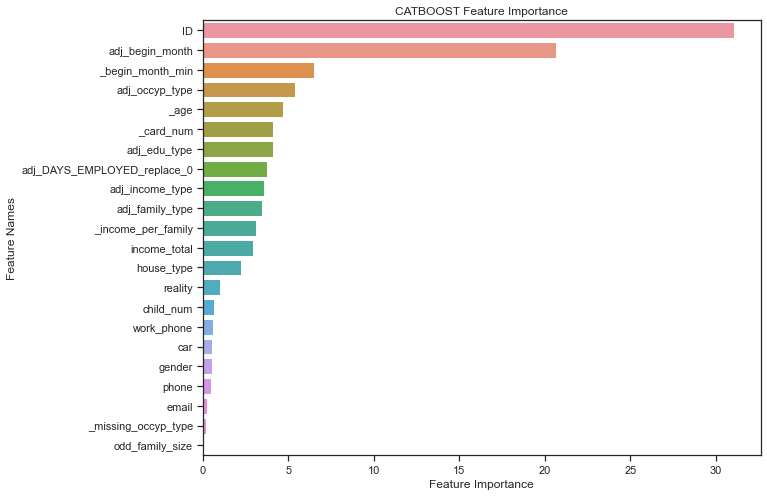

In [183]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [189]:
for i in range(3):
    submit[str(i)] = (cat_pred_test/2)[:,i]

In [203]:
submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    9301
1     699
dtype: int64

In [191]:
submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_basic03.csv', index = False)

## OPTUNA

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    

    gbm = cb.CatBoostClassifier(**param)
    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)
    
    model_cat = CatBoostClassifier(**param)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return log_loss

In [77]:
n_fold = 5
seed = 42

def objective(trial):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    folds=[]
    for train_idx, valid_idx in skfold.split(X, y):
            folds.append((train_idx, valid_idx))
            
    cat_pred = np.zeros((X.shape[0], n_class))
    cat_pred_test = np.zeros((X_test.shape[0], n_class))
    cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1200, 4000, 400)
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 12, 2),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model_folds = []    
    for fold in range(n_fold):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(**param)
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=200)
        
        model_folds.append(model_cat)
        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        cat_pred_test += model_cat.predict_proba(X_test) / n_fold
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
    logloss = log_loss(y, cat_pred)
    return logloss





In [79]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2021-06-13 11:47:08,087] A new study created in memory with name: no-name-819cfa5d-a383-4192-8fe7-8028ccb21c65
Custom logger is already specified. Specify more than one logger at same time is not thread safe.


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0501583	test: 1.0503820	best: 1.0503820 (0)	total: 24.1ms	remaining: 24.1s
100:	learn: 0.7313911	test: 0.6861480	best: 0.6861477 (98)	total: 1.91s	remaining: 17s
200:	learn: 0.7188599	test: 0.6692676	best: 0.6692675 (199)	total: 3.52s	remaining: 14s
300:	learn: 0.7153297	test: 0.6668464	best: 0.6668155 (294)	total: 5.16s	remaining: 12s
400:	learn: 0.7119636	test: 0.6647809	best: 0.6647809 (400)	total: 6.79s	remaining: 10.1s
500:	learn: 0.7094833	test: 0.6641824	best: 0.6641638 (491)	total: 8.37s	remaining: 8.34s
600:	learn: 0.7068466	test: 0.6624817	best: 0.6624817 (600)	total: 10.1s	remaining: 6.7s
700:	learn: 0.7043704	test: 0.6623856	best: 0.6622581 (634)	total: 11.9s	remaining: 5.06s
800:	learn: 0.7023935	test: 0.6616710	best: 0.6616710 (800)	total: 13.7s	remaining: 3.39s
900:	learn: 0.7002756	test: 0.6614710	best: 0.6613624 (810)	total: 15.4s	remaining: 1.69s
999:	learn: 0.6982415	test: 0.661292

Learning rate set to 0.115128
0:	learn: 1.0501767	test: 1.0501851	best: 1.0501851 (0)	total: 20.6ms	remaining: 20.6s
100:	learn: 0.7343519	test: 0.7128669	best: 0.7128608 (97)	total: 1.87s	remaining: 16.7s
200:	learn: 0.7203634	test: 0.6976482	best: 0.6975920 (198)	total: 3.75s	remaining: 14.9s
300:	learn: 0.7133846	test: 0.6908183	best: 0.6908183 (300)	total: 5.72s	remaining: 13.3s
400:	learn: 0.7096286	test: 0.6877630	best: 0.6877629 (399)	total: 7.61s	remaining: 11.4s
500:	learn: 0.7069707	test: 0.6868629	best: 0.6867451 (486)	total: 9.54s	remaining: 9.5s
600:	learn: 0.7049741	test: 0.6863671	best: 0.6861828 (595)	total: 11.4s	remaining: 7.54s
700:	learn: 0.7022152	test: 0.6849481	best: 0.6848529 (696)	total: 13.3s	remaining: 5.66s
800:	learn: 0.6998803	test: 0.6839656	best: 0.6839514 (798)	total: 15.2s	remaining: 3.77s
900:	learn: 0.6982440	test: 0.6839153	best: 0.6837768 (878)	total: 17s	remaining: 1.87s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.68377676

[I 2021-06-13 11:51:14,859] Trial 0 finished with value: 0.6708670298294468 and parameters: {'colsample_bylevel': 0.07591531396851062, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6708670298294468.


999:	learn: 0.6968355	test: 0.6624694	best: 0.6623340 (925)	total: 19.4s	remaining: 0us

bestTest = 0.6623340001
bestIteration = 925

Shrink model to first 926 iterations.
CV Log Loss Score: 0.662334
	Log Loss: 0.670867

----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0463447	test: 1.0462352	best: 1.0462352 (0)	total: 9.01ms	remaining: 9.01s
100:	learn: 0.7344867	test: 0.6948548	best: 0.6948548 (100)	total: 648ms	remaining: 5.77s
200:	learn: 0.7198421	test: 0.6792878	best: 0.6792787 (198)	total: 1.31s	remaining: 5.23s
300:	learn: 0.7121361	test: 0.6754204	best: 0.6754154 (299)	total: 2.01s	remaining: 4.66s
400:	learn: 0.7054217	test: 0.6702749	best: 0.6702722 (398)	total: 2.68s	remaining: 4.01s
500:	learn: 0.6993571	test: 0.6674394	best: 0.6673381 (465)	total: 3.38s	remaining: 3.36s
600:	learn: 0.6951386	test: 0.6665847	best: 0.6665200 (569)	total: 4.01s	remaining: 2.67s
700:	learn: 0.6905318	test: 0.6646623	best: 0.6646620 (699)	total: 4.67s	remai

400:	learn: 0.7026253	test: 0.6758973	best: 0.6756528 (393)	total: 2.77s	remaining: 4.13s
500:	learn: 0.6973204	test: 0.6730608	best: 0.6729365 (494)	total: 3.4s	remaining: 3.38s
600:	learn: 0.6924914	test: 0.6720327	best: 0.6720327 (600)	total: 4.1s	remaining: 2.72s
700:	learn: 0.6884554	test: 0.6712080	best: 0.6711310 (699)	total: 4.77s	remaining: 2.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6711310278
bestIteration = 699

Shrink model to first 700 iterations.
CV Log Loss Score: 0.671131

----------------- Fold 8 -----------------

Learning rate set to 0.115128
0:	learn: 1.0412101	test: 1.0428082	best: 1.0428082 (0)	total: 9.71ms	remaining: 9.71s
100:	learn: 0.7347352	test: 0.7223969	best: 0.7223969 (100)	total: 690ms	remaining: 6.14s
200:	learn: 0.7193153	test: 0.7066199	best: 0.7066199 (200)	total: 1.33s	remaining: 5.3s
300:	learn: 0.7102322	test: 0.6994544	best: 0.6994011 (299)	total: 1.99s	remaining: 4.61s
400:	learn: 0.7031722	test: 0.6946435	best: 

[I 2021-06-13 11:52:44,862] Trial 1 finished with value: 0.6718221810214896 and parameters: {'colsample_bylevel': 0.08735162877190666, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.3902893698102545}. Best is trial 0 with value: 0.6708670298294468.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6618364683
bestIteration = 882

Shrink model to first 883 iterations.
CV Log Loss Score: 0.661836
	Log Loss: 0.671822

----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0439884	test: 1.0430371	best: 1.0430371 (0)	total: 25.9ms	remaining: 25.9s
100:	learn: 0.7353186	test: 0.6932719	best: 0.6932410 (99)	total: 2.38s	remaining: 21.2s
200:	learn: 0.7213056	test: 0.6775516	best: 0.6775390 (190)	total: 4.67s	remaining: 18.6s
300:	learn: 0.7146040	test: 0.6725102	best: 0.6724517 (294)	total: 6.92s	remaining: 16.1s
400:	learn: 0.7082663	test: 0.6683372	best: 0.6681456 (383)	total: 9.29s	remaining: 13.9s
500:	learn: 0.7043603	test: 0.6666774	best: 0.6666774 (500)	total: 11.6s	remaining: 11.5s
600:	learn: 0.7009361	test: 0.6655458	best: 0.6655317 (596)	total: 13.8s	remaining: 9.15s
700:	learn: 0.6982566	test: 0.6652502	best: 0.6652502 (700)	total: 16.1s	remaining: 6.87s
800:	learn: 0.6957855	

100:	learn: 0.7373865	test: 0.7079241	best: 0.7079241 (100)	total: 2.35s	remaining: 20.9s
200:	learn: 0.7214037	test: 0.6883215	best: 0.6883215 (200)	total: 4.63s	remaining: 18.4s
300:	learn: 0.7135031	test: 0.6818191	best: 0.6817711 (294)	total: 6.9s	remaining: 16s
400:	learn: 0.7084980	test: 0.6796929	best: 0.6796810 (394)	total: 9.2s	remaining: 13.7s
500:	learn: 0.7037788	test: 0.6768109	best: 0.6768109 (500)	total: 11.7s	remaining: 11.6s
600:	learn: 0.7002157	test: 0.6758779	best: 0.6758038 (590)	total: 14s	remaining: 9.26s
700:	learn: 0.6971745	test: 0.6744524	best: 0.6744370 (695)	total: 16.2s	remaining: 6.91s
800:	learn: 0.6940903	test: 0.6741048	best: 0.6738654 (761)	total: 18.5s	remaining: 4.6s
900:	learn: 0.6899982	test: 0.6723897	best: 0.6723896 (899)	total: 20.9s	remaining: 2.29s
999:	learn: 0.6872820	test: 0.6729048	best: 0.6723896 (899)	total: 23.3s	remaining: 0us

bestTest = 0.6723896182
bestIteration = 899

Shrink model to first 900 iterations.
CV Log Loss Score: 0.6723

500:	learn: 0.7043422	test: 0.6676598	best: 0.6676457 (498)	total: 12s	remaining: 12s
600:	learn: 0.7003696	test: 0.6658514	best: 0.6657786 (572)	total: 14.4s	remaining: 9.55s
700:	learn: 0.6958493	test: 0.6641420	best: 0.6641404 (685)	total: 16.8s	remaining: 7.16s
800:	learn: 0.6928394	test: 0.6628780	best: 0.6628780 (799)	total: 19.2s	remaining: 4.78s
900:	learn: 0.6901480	test: 0.6619728	best: 0.6619728 (900)	total: 21.6s	remaining: 2.37s


[I 2021-06-13 11:58:24,041] Trial 2 finished with value: 0.672089778045155 and parameters: {'colsample_bylevel': 0.09506074103465388, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.684640072331112}. Best is trial 0 with value: 0.6708670298294468.


999:	learn: 0.6872941	test: 0.6622276	best: 0.6615582 (914)	total: 24s	remaining: 0us

bestTest = 0.6615581585
bestIteration = 914

Shrink model to first 915 iterations.
CV Log Loss Score: 0.661558
	Log Loss: 0.672090


In [80]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 3
Best trial:
  Value: 0.6708670298294468
  Params: 
    colsample_bylevel: 0.07591531396851062
    depth: 3
    boosting_type: Ordered
    bootstrap_type: MVS


In [83]:
trial.params

{'colsample_bylevel': 0.07591531396851062,
 'depth': 3,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [82]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**trial.params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0501583	test: 1.0503820	best: 1.0503820 (0)	total: 19.2ms	remaining: 19.2s
100:	learn: 0.7313911	test: 0.6861480	best: 0.6861477 (98)	total: 1.65s	remaining: 14.7s
200:	learn: 0.7188599	test: 0.6692676	best: 0.6692675 (199)	total: 3.28s	remaining: 13s
300:	learn: 0.7153297	test: 0.6668464	best: 0.6668155 (294)	total: 4.92s	remaining: 11.4s
400:	learn: 0.7119636	test: 0.6647809	best: 0.6647809 (400)	total: 6.5s	remaining: 9.71s
500:	learn: 0.7094833	test: 0.6641824	best: 0.6641638 (491)	total: 8.16s	remaining: 8.13s
600:	learn: 0.7068466	test: 0.6624817	best: 0.6624817 (600)	total: 9.85s	remaining: 6.54s
700:	learn: 0.7043704	test: 0.6623856	best: 0.6622581 (634)	total: 11.6s	remaining: 4.97s
800:	learn: 0.7023935	test: 0.6616710	best: 0.6616710 (800)	total: 13.4s	remaining: 3.34s
900:	learn: 0.7002756	test: 0.6614710	best: 0.6613624 (810)	total: 15.1s	remaining: 1.66s
999:	learn: 0.6982415	test: 0.66

Learning rate set to 0.115128
0:	learn: 1.0501767	test: 1.0501851	best: 1.0501851 (0)	total: 21ms	remaining: 21s
100:	learn: 0.7343519	test: 0.7128669	best: 0.7128608 (97)	total: 2s	remaining: 17.8s
200:	learn: 0.7203634	test: 0.6976482	best: 0.6975920 (198)	total: 4.02s	remaining: 16s
300:	learn: 0.7133846	test: 0.6908183	best: 0.6908183 (300)	total: 6.07s	remaining: 14.1s
400:	learn: 0.7096286	test: 0.6877630	best: 0.6877629 (399)	total: 8.1s	remaining: 12.1s
500:	learn: 0.7069707	test: 0.6868629	best: 0.6867451 (486)	total: 10.2s	remaining: 10.1s
600:	learn: 0.7049741	test: 0.6863671	best: 0.6861828 (595)	total: 12.2s	remaining: 8.11s
700:	learn: 0.7022152	test: 0.6849481	best: 0.6848529 (696)	total: 14.3s	remaining: 6.1s
800:	learn: 0.6998803	test: 0.6839656	best: 0.6839514 (798)	total: 16.3s	remaining: 4.06s
900:	learn: 0.6982440	test: 0.6839153	best: 0.6837768 (878)	total: 18.4s	remaining: 2.02s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6837767631
bestI

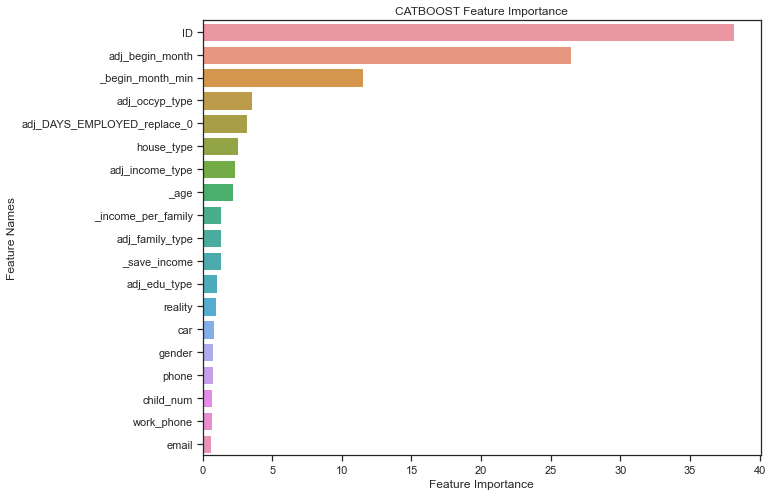

In [84]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [85]:
for i in range(3):
    submit[str(i)] = cat_pred_test[:,i]

In [86]:
submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_basic+optuna.csv', index = False)